Who is the best character in Mario Kart? This is actually a non-trivial question, because the characters have widely varying stats across a number of attributes (for the unfamiliar, Mario Kart is a video game where you select characters from the Nintendo universe and race them against each other in cartoonish go-karts). The question is compounded when you consider the modifications introduced by the the various karts and tires players can select from. In general it isn't possible to optimize across multiple dimensions simultaneously, however some setups are undeniably worse than others. The question for an aspiring Mario Kart champion is "How can one pick a character / kart / tire combination that is in some sense optimal, even if there isn't one 'best' option?" To answer this question we turn to one of Mario's compatriots, the nineteenth century Italian economist Vilfredo Pareto who introduced the concept of [Pareto efficiency](https://en.wikipedia.org/wiki/Pareto_efficiency) and the related [Pareto frontier](https://en.wikipedia.org/wiki/Pareto_efficiency#Pareto_frontier).

The concept of Pareto efficiency applies to situations where a finite pool of resources is being allocated among several competing groups. A particular allocation is said to be Pareto efficient if it is impossible to increase the portion assigned to any group without also decreasing the portion assigned to some other group. The set of allocations which are Pareto efficient define the Pareto frontier. As with many things, this is more easily explained with a picture (courtesy of wikipedia).

The elements in red lie on the Pareto frontier: for each element in the set an increase along one axis requires a decrease along the other. 

We can apply this same concept to Mario Kart: the resources are total stat points and the groups are the individual attributes, for instance, speed, acceleration, or traction. (In general, characters in Mario Kart have the same number of total stat points, and differ only in their allocation). Speed and acceleration are generally the two most important attributes of any given setup, so the goal of this post is to identify those configurations that lie on the Pareto frontier for speed and acceleration.

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it

from sklearn.cluster import KMeans

sns.set_context('talk')

As usual, we start with a little data wrangling to get things into a form we can use. One particular quirk of Mario Kart is that while there are a couple dozen characters, lots of them have identical stats. We'll start by picking out one character from each stat group to use in this analysis (and then do the same for karts and tires).

In [7]:
# originally from https://github.com/woodnathan/MarioKart8-Stats, added DLC and fixed a few typos
bodies = pd.read_csv('bodies.csv')
chars = pd.read_csv('characters.csv')
gliders = pd.read_csv('gliders.csv')
tires = pd.read_csv('tires.csv')

# use only stock (non-DLC) characters / karts / tires
chars = chars.loc[chars['DLC']==0]
bodies = bodies.loc[bodies['DLC']==0]
tires = tires.loc[tires['DLC']==0]
gliders = gliders.loc[gliders['DLC']==0]

stat_cols = bodies.columns[2:-1]
main_cols = ['Weight','Speed','Acceleration','Handling','Traction']

# lots of characters/karts/tires are exactly the same. here we just want one from each stat type
chars_unique = chars.drop_duplicates(subset=stat_cols).set_index('Character')[stat_cols].sort_values('Weight')
bodies_unique = bodies.drop_duplicates(subset=stat_cols).set_index('Body')[stat_cols].sort_values('Acceleration')
tires_unique = tires.drop_duplicates(subset=stat_cols).set_index('Tire')[stat_cols].sort_values('Speed')

n_uniq_chars = len(chars_unique)
n_uniq_bodies = len(bodies_unique)
n_uniq_tires = len(tires_unique)

# add a column indicating which category each character/kart/tire is in
chars['char_class'] = KMeans(n_uniq_chars, random_state=0).fit_predict(chars[stat_cols])
bodies['body_class'] = KMeans(n_uniq_bodies).fit_predict(bodies[stat_cols])
tires['tire_class'] = KMeans(n_uniq_tires).fit_predict(tires[stat_cols])

# change the character class labels so that they correspond to weight order
# without DLC
char_class_dict = dict(zip([3, 0, 5, 4, 2, 6, 1], [0, 1, 2, 3, 4, 5, 6]))
# with DLC
# char_class_dict = dict(zip([0, 3, 2, 7, 8, 4, 1, 6, 5], [0, 1, 2, 3, 4, 5, 6, 7, 8]))
chars['char_class'] = chars['char_class'].apply(lambda c: char_class_dict[c])

# only two types of gliders, one of which is pretty clearly just better
glider_best = gliders.loc[gliders['Glider']=='Flower']

From here on out, I'll refer to the character (or kart, or tire) class by the name of its first member. For example, in the heatmap below the row labelled 'Peach' also describes the stats for Daisy and Yoshi. The complete class memberships are listed at the end of the post in case you want to see where your favorite character lands.

There are seven classes of characters, let's have a look at how their stats compare.

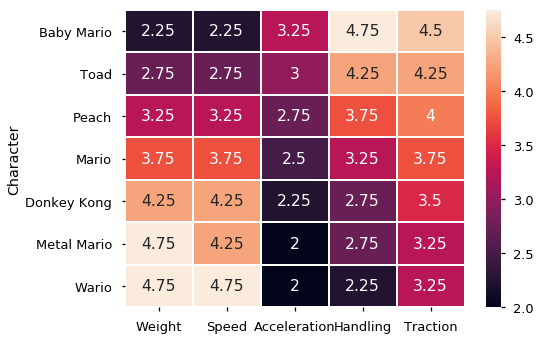

In [8]:
# plot a heatmap of the stats for each component class
fig, ax = plt.subplots(1,1, figsize=(8,5))

sns.heatmap(chars_unique[main_cols], annot=True, ax=ax, linewidth=1, fmt='.3g')
    
fig.tight_layout()

The most obvious trend is the trade-off between speed and acceleration; heavy characters have good speed but bad acceleration, while light characters have snappy acceleration but a low top speed. There are variations in the other stats as well, but to a large extend the speed and acceleration dominate the performace of a particular setup so we'll be ignoring the rest of the stats.

Karts and tires modify the base stats of the characters; the final configuration is a sum of the character's stats and the kart / tire modifiers. As with characters, there are dozens of karts and tires but only a few categories with different stats.

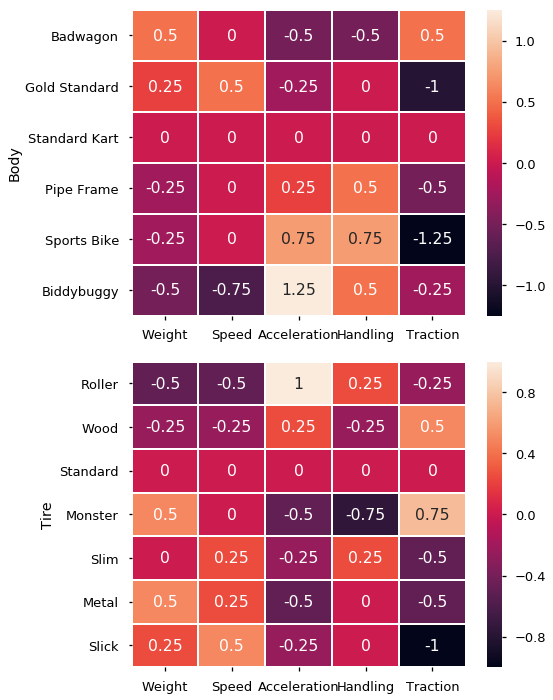

In [9]:
# plot a heatmap of the stats for each component class
fig, axes = plt.subplots(2,1, figsize=(8,10))

tables = [bodies_unique, tires_unique]
keys = ['Body', 'Tire']

for ax, table, key in zip(axes, tables, keys):
    sns.heatmap(table[main_cols], annot=True, ax=ax, linewidth=1, fmt='.3g')
    
fig.tight_layout()

The trends here are less obvious, but they generally agree with what we saw in the character stats: improvements in speed come at the expense of acceleration, and vice versa.

Our goal is to find all the configurations that have an optimal combination of speed and acceleration, so the next step is to compute the stats for each unique (character, kart, tire) combination.

In [10]:
def check(char_name, body_type, tire_type):
    # find the stats for each element of the configuration
    character = chars.loc[chars['Character']==char_name]
    kart = bodies.loc[bodies['Body']==body_type]
    wheels = tires.loc[tires['Tire']==tire_type]

    # the total stats for the configuration are just the sum of the components
    stats = pd.concat([character[stat_cols], kart[stat_cols], wheels[stat_cols], glider_best[stat_cols]]).sum()
    
    # index the row by the configuration (character, kart, tire)
    index = pd.MultiIndex.from_tuples([(char_name, body_type, tire_type)], names=['Character', 'Body', 'Tire'])
    
    df = pd.DataFrame(stats).transpose()
    df.index = index
    return df

# generate list of tuples for every possible configuration
config_all = it.product(chars_unique.index, bodies_unique.index, tires_unique.index)

# generate a dataframe with stats for each unique configuration
config_base = pd.DataFrame()
for (c,b,t) in config_all:
    this_config = check(c,b,t)
    config_base = config_base.append(this_config)

Equipped with the statistics for each possible combination, we can can plot the speed vs the acceleration of each possible setup, and identify those that lie on the Pareto frontier.

In [27]:
from beakerx import *
# returns True if the row is at the pareto frontier for variables xlabel and ylabel
def is_pareto_front(row, xlabel, ylabel):
    
    x = row[xlabel]
    y = row[ylabel]
    
    # look for points with the same y value but larger x value
    is_max_x = config_base.loc[config_base[ylabel]==y].max()[xlabel] <= x
    # look for points with the same x value but larger y value
    is_max_y = config_base.loc[config_base[xlabel]==x].max()[ylabel] <= y
    # look for points that are larger in both x and y
    is_double = len(config_base.loc[(config_base[xlabel]>x) & (config_base[ylabel]>y)])==0
    
    return is_max_x and is_max_y and is_double

# array of True/False indicating whether the corresponding row is on the pareto frontier
is_pareto = config_base.apply(lambda row: is_pareto_front(row, 'Speed', 'Acceleration'), axis=1)

# just the configurations that are on the pareto frontier
config_pareto = config_base.ix[is_pareto].sort_values('Speed')

TableDisplay(config_base)

/Users/mackaber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


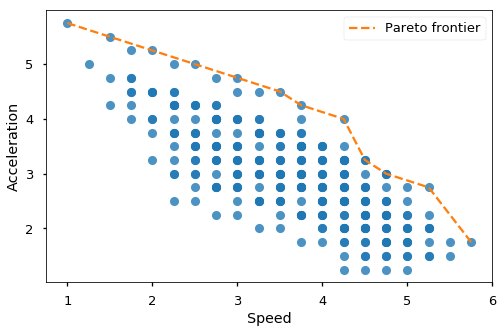

In [36]:
# plot all the configurations
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.regplot(x='Speed', y='Acceleration', data=config_base, fit_reg=False, ax=ax)
            
# plot the pareto frontier
plt.plot(config_pareto['Speed'], config_pareto['Acceleration'], '--', label='Pareto frontier', alpha=1.0)

plt.xlim([0.75,6]);
plt.legend(loc='best');

Looks like the optimal configurations make up a fairly small subset of the total possible setups. In fact, we can quantify this.

In [14]:
# number of possible combinations
print('Possible combinations    : ',len(list(it.product(chars.index, bodies.index, tires.index, gliders.index))))

# number of combinations with different statistics
print('Unique stat combinations : ',len(config_base.drop_duplicates(subset=stat_cols)))

# number of optimal combinations (considering only speed and acceleration)
print('Optimal combinations     : ',len(config_pareto))

Possible combinations    :  149760
Unique stat combinations :  294
Optimal combinations     :  15


Let's have a look at what these optimal configurations look like.

In [16]:
print(config_base.ix[is_pareto][['Speed','Acceleration']].sort_values('Speed'))

                                    Speed  Acceleration
Character   Body          Tire                         
Baby Mario  Biddybuggy    Roller     1.00          5.75
Toad        Biddybuggy    Roller     1.50          5.50
Peach       Biddybuggy    Roller     2.00          5.25
Mario       Biddybuggy    Roller     2.50          5.00
Donkey Kong Biddybuggy    Roller     3.00          4.75
Wario       Biddybuggy    Roller     3.50          4.50
Donkey Kong Sports Bike   Roller     3.75          4.25
Wario       Sports Bike   Roller     4.25          4.00
                          Wood       4.50          3.25
            Biddybuggy    Slick      4.50          3.25
Donkey Kong Sports Bike   Slick      4.75          3.00
Wario       Gold Standard Roller     4.75          3.00
            Sports Bike   Standard   4.75          3.00
                          Slick      5.25          2.75
            Gold Standard Slick      5.75          1.75


/Users/mackaber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Unless you're going all-in on acceleration, it looks like a heavy character is the way to go; the two heaviest character classes (Wario and Donkey Kong) account for 11/15 of the Pareto-optimal configurations.

We can also look at the other main stats for each of these configurations.

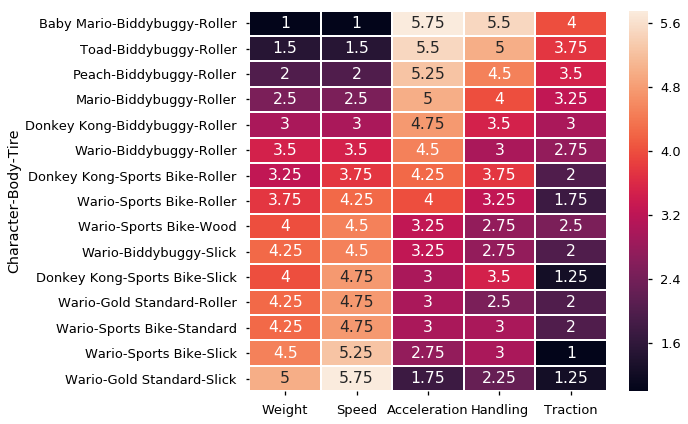

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,7))
sns.heatmap(config_pareto[main_cols].sort_values('Speed'), annot=True, ax=ax, linewidth=1, fmt='.3g');

So there it is, if speed and acceleration are your main concerns then one of these 15 configurations is your best bet.

Sometimes an optimal configuration isn't what you're looking for though (say, because your roommate threatened to stop playing if there wasn't some sort of handicap, to choose a random example). In that case, we can explore all the possible configurations with a quick [bokeh](http://bokeh.pydata.org/en/latest/) interactive graphic. I'll omit the code here, but you can find it in the [notebook](/notebooks/mario-kart.ipynb) for this post.

In [19]:
# note: needs modifications from https://github.com/josherick/bokeh/tree/2715_add_callbacks_to_groups to work
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, CustomJS
from bokeh.models.widgets import CheckboxButtonGroup

from bokeh.models.widgets import Dropdown
from bokeh.io import output_file, show, vform

output_notebook()
output_file('bokeh_plot.html')

ImportError: cannot import name 'vform'

In [20]:
def rgb_to_hex(rgb_tuple):
    tuple_255 = tuple([int(255*c) for c in rgb_tuple])
    hex_str = '#%02x%02x%02x' % tuple_255
    return hex_str

# make the color palette for plotting
palette = sns.color_palette("Set1", n_colors=n_uniq_chars)
pal_hex = [rgb_to_hex(color) for color in palette]

# collect all the data from each df (chars, bodies, tires)
bokeh_data = config_base.join(chars.set_index('Character')['char_class'])\
.join(bodies.set_index('Body')['body_class'])\
.join(tires.set_index('Tire')['tire_class'])


# store all the original data in this ColumnDataSource
source_all = ColumnDataSource(
    data = dict(
        x=config_base['Speed'],
        y=config_base['Acceleration'],
        character=config_base.index.get_level_values('Character'),
        kart=config_base.index.get_level_values('Body'),
        tire=config_base.index.get_level_values('Tire'),
        char_class=bokeh_data.char_class,
        color=[pal_hex[i] for i in bokeh_data['char_class']]
    )
)

# store just what is currently being shown in the plot in this CDS
source_plot = ColumnDataSource(
    data = dict(
        x=config_base['Speed'],
        y=config_base['Acceleration'],
        character=config_base.index.get_level_values('Character'),
        kart=config_base.index.get_level_values('Body'),
        tire=config_base.index.get_level_values('Tire'),
        char_class=bokeh_data.char_class,
        color=[pal_hex[i] for i in bokeh_data['char_class']]
    )
)

hover = HoverTool()
hover.tooltips = [
    ("Character", "@character"),
    ("Kart", "@kart"),
    ("Tires", "@tire")
]

# some javascript to update the plot based on which characters are selected
callback = CustomJS(args=dict(s_all=source_all, s_plot=source_plot), code="""
        var data = s_all.get('data');
        var show_class = cb_obj.get('active')
        x = data['x']
        y = data['y']
        char_class = data['char_class']
        
        var d2 = s_plot.get('data');
        d2['x'] = []
        d2['y'] = []
        d2['character'] = []
        d2['kart'] = []
        d2['tire'] = []
        d2['char_class'] = []
        d2['color'] = []
        
        var colors = '#e41a1c,#377eb7,#4dae4a,#994ea1,#ff8100,#fdfb32,#a7572b,#f481bd,#999999'.split(',');
        
        for (i = 0; i < x.length; i++) {
            if(show_class.indexOf(char_class[i]) != -1)
                {  
                    d2['x'].push(data['x'][i])
                    d2['y'].push(data['y'][i])
                    d2['character'].push(data['character'][i])
                    d2['kart'].push(data['kart'][i])
                    d2['tire'].push(data['tire'][i])
                    d2['char_class'].push(data['char_class'][i])
                    d2['color'].push(colors[data['char_class'][i]])
                }
        }

        s_plot.trigger('change');
        
        for (i = 0; i < speed.length; i++) {
            if(blockedTile.indexOf("118") != -1)
                {  
                    // element found
                }
            y[i] = Math.pow(x[i], f)
        }
        source.trigger('change');
    """)

# make checkboxes for each character class
checkbox_group = CheckboxButtonGroup(
    labels=list(config_base.index.get_level_values('Character').unique()), 
    active=list(range(n_uniq_chars)),
    callback=callback)

TOOLS = [hover]

p = figure(plot_width=600, plot_height=600, y_range=(0.8,6), x_range=(0.8, 6), tools=TOOLS)

p.circle('x', 'y', size=8, source=source_plot, fill_color='color', line_color='#000000')

# janky way to do custom legend: plot 1 point for each color, then cover with white circle
for char, color in zip(chars_unique.index.values, pal_hex):
    p.circle(1.5, 1.5, size=8, line_color='#000000', fill_color=color, legend=char)
p.circle(1.5, 1.5, size=10, fill_color='#FFFFFF', line_color='#FFFFFF')

p.xaxis.axis_label = 'Speed'
p.yaxis.axis_label = 'Acceleration'


show(vform(checkbox_group,p)) # show the results

NameError: name 'vform' is not defined

A few observations:

- Heavy characters are more versatile than light characters. While Wario's possible configurations can achieve about 77% of the max acceleration, Baby Mario can only get up to 50% of the max speed.
- Metal Mario / Pink Gold Peach are the only characters that have no configurations on the Pareto frontier. 
- The Badwagon really is bad. Nearly every configuration on the 'anti-Pareto frontier' (i.e. the worst possible combinations) involves karts from the Badwagon class.

And finally, in case you have a particular attachment to one of the characters (or karts / tires) you can look up which class he / she / it belongs to below. 

In [28]:
# print out the various components, grouped by category
tables = [chars, bodies, tires]
keys = ['char_class', 'body_class', 'tire_class']
columns = ['Character', 'Body', 'Tire']

for table, key, col in zip(tables, keys, columns):
    print(col + ' Classes')
    print('*****************')
    for class_ in table[key].unique():
        class_list = table.loc[table[key]==class_][col].values
        print(', '.join(class_list))
        
    print()

Character Classes
*****************
Baby Mario, Baby Luigi, Baby Peach, Baby Daisy, Baby Rosalina, Lemmy Koopa, Mii Light
Toad, Shy Guy, Koopa Troopa, Lakitu, Wendy Koopa, Larry Koopa, Toadette
Peach, Daisy, Yoshi
Mario, Luigi, Iggy Koopa, Ludwig Koopa, Mii Medium
Donkey Kong, Waluigi, Rosalina, Roy Koopa
Metal Mario, Pink Gold Peach
Wario, Bowser, Morton Koopa, Mii Heavy

Body Classes
*****************
Standard Kart, Prancer, Cat Cruiser, Sneeker, The Duke, Teddy Buggy
Gold Standard, Mach 8, Circuit Special, Sports Coupe
Badwagon, TriSpeeder, Steel Driver, Standard ATV
Biddybuggy, Landship, Mr. Scooty
Pipe Frame, Standard Bike, Flame Ride, Varmit, Wild Wiggler
Sports Bike, Jet Bike, Comet, Yoshi Bike

Tire Classes
*****************
Standard, Blue Standard, Offroad, Retro Offroad
Monster, Hot Monster
Slick, Cyber Slick
Roller, Azure Roller, Button
Slim, Crimson Slim
Metal, Gold
Wood, Sponge, Cushion



The IPython notebook for this post is [here](/notebooks/mario-kart.ipynb) and the data is [here](/data/mariokart.tar.gz).